In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data='data/'
X_train=np.load(data+'X_part1.npy')
X_val=np.load(data+'X_val_part1.npy')
y_val=np.load(data+'y_val_part1.npy')

In [4]:
print(X_train.shape,X_val.shape,y_val.shape)

(307, 2) (307, 2) (307,)


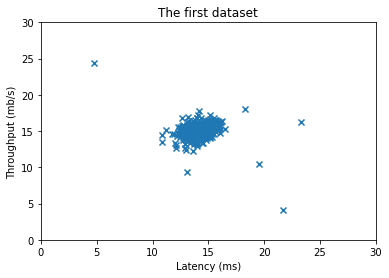

In [7]:
plt.scatter(X_train[:,0],X_train[:,1],marker='x')
# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

Maximum likelihood estimate

In [10]:
def MLE(X):
    m,n=X.shape
    mu=(1/m)*np.sum(X,axis=0)
    var=np.zeros(n,dtype=int)
    for i in range(n):
        var[i]=np.sum(np.square(X[:,i]-mu[i]),axis=0)
    var=(1/m)*var
    return mu,var

mu,var=MLE(X_train)
print(mu,var)

[14.11222578 14.99771051] [1.83061889 1.70684039]


In [15]:
def multivariationgaussian(X,mu,var):
    k=len(mu)
    X=X-mu
    if var.ndim == 1:
        var = np.diag(var)
    p=(2*np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * np.exp(-0.5*np.sum(np.matmul(X,np.linalg.pinv(var))*X,axis=1))
    return p

p=multivariationgaussian(X_train,mu,var)
print(p.shape)

(307,)


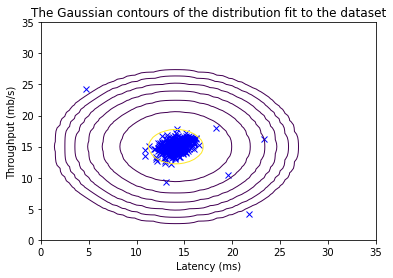

In [17]:
def visualize_fit(X, mu, var):
    """
    This visualization shows you the 
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariationgaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
        
    # Set the title
    plt.title("The Gaussian contours of the distribution fit to the dataset")
    # Set the y-axis label
    plt.ylabel('Throughput (mb/s)')
    # Set the x-axis label
    plt.xlabel('Latency (ms)')

visualize_fit(X_train,mu,var)

In [19]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000

    for epsilon in np.arange(min(p_val), max(p_val), step_size):

        ### START CODE HERE ### 
        predictions=(p_val<epsilon)
        tp=sum((predictions==1)&(y_val==1))
        fp=sum((predictions==1)&(y_val==0))
        fn=sum((predictions==0)&(y_val==1))
        prec=tp/(tp+fp)
        recall=tp/(tp+fn)
        F1=2*prec*recall/(prec+recall)
        
        ### END CODE HERE ### 
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

p_val=multivariationgaussian(X_val,mu,var)
epsilon,F1=select_threshold(y_val,p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

C:\Users\212803739\AppData\Local\Temp\ipykernel_10304\1121713094.py:29: RuntimeWarning: invalid value encountered in long_scalars
  prec=tp/(tp+fp)


Best epsilon found using cross-validation: 9.003445e-05
Best F1 on Cross Validation Set: 0.875000


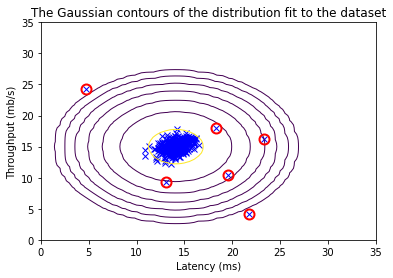

In [20]:
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)